# Influence of home/away fixtures on points

In this script, I will look at the distribution of points between home and away fixtures.

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

fs = 14; # font size for plots
fh = 6; # figure height for plots

#### Histogram Outline fucntion to allow better viewing of histogram overlays

In [2]:
import numpy as np

def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

#### Read files

In [3]:
data = pd.read_csv('../../data/csv/data01_full.csv')
data.head()

,id,kickoff_time,kickoff_time_formatted,team_h_score,team_a_score,was_home,round,total_points,value,transfers_balance,...,offside,target_missed,fouls,dribbles,element,fixture,opponent_team,team,element_type,element_name
0,1,2018-08-12T15:00:00Z,12 Aug 16:00,0,2,True,1,3,50,0,...,0,0,0,0,0,0,12,0,0,Cech
1,526,2018-08-18T16:30:00Z,18 Aug 17:30,3,2,False,2,3,50,188,...,0,0,0,0,0,13,5,0,0,Cech
2,1053,2018-08-25T14:00:00Z,25 Aug 15:00,3,1,True,3,3,50,8540,...,0,0,0,0,0,20,18,0,0,Cech
3,1584,2018-09-02T12:30:00Z,02 Sep 13:30,2,3,False,4,1,50,9582,...,0,0,0,0,0,32,4,0,0,Cech
4,2121,2018-09-15T14:00:00Z,15 Sep 15:00,1,2,False,5,2,50,-3297,...,0,0,0,0,0,45,14,0,0,Cech


In [4]:
print(data.shape)

(21790, 57)


In [5]:
print(len(data)*0.35)
print(len(data)*0.45)

7626.499999999999
9805.5


#### Filter players
Look at only players who have played more than 59 minutes, and split by home/away matches. Players are awarded 0 points for not playing, 1 point for playing 1-59 minutes, and 2 points for playing 60+ minutes.

In [6]:
# Choose only players with >= 60 minutes, and separate by home and away.
valid_players = data[data['minutes']>=60]
home_players = valid_players[valid_players['was_home']]
away_players = valid_players[~valid_players['was_home']]

Plot results

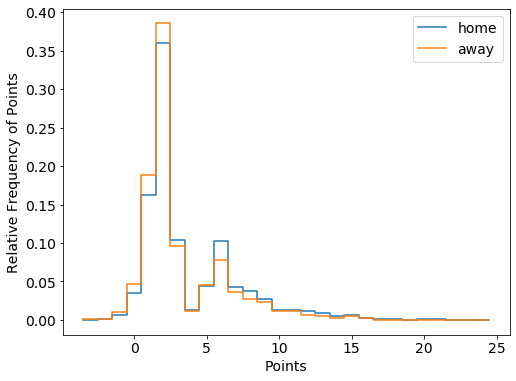

In [7]:
plt.figure(figsize=(8,fh))
val_min = np.min(valid_players['total_points'])
val_max = np.max(valid_players['total_points'])
val_range = val_max-val_min

bins = np.linspace(val_min-0.5, val_max+0.5, val_range+2)
bin_centre = np.linspace(val_min, val_max, val_range+1)

(b_h, n_h) = histOutline(home_players['total_points'], bins=bins);
n_h = n_h/len(home_players)
plt.plot(b_h, n_h);

(b_a, n_a) = histOutline(away_players['total_points'], bins=bins);
n_a = n_a/len(away_players)
plt.plot(b_a, n_a);

plt.legend(['home', 'away'], fontsize=fs);
plt.xlabel('Points', fontsize=fs);
plt.ylabel('Relative Frequency of Points', fontsize=fs);
plt.xticks(fontsize=fs);
plt.yticks(fontsize=fs);

plt.savefig('../../data/figures/home_away_hist.svg', format='svg')

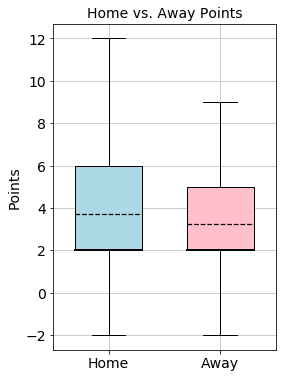

In [8]:
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(1,1,1)

data = [home_players['total_points'].values, away_players['total_points'].values]

bplot = plt.boxplot(data, widths=0.6, patch_artist=True, showmeans=True, meanline=True, showfliers=False)

for median in bplot['medians']:
    median.set(color='k', linewidth=2,)
    
for mean in bplot['means']:
    mean.set(color='k', linewidth=1.25,)
    
colors = ['lightblue', 'pink']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks([1,2], ['Home', 'Away'], fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel('Points', fontsize=fs)
plt.grid(True, c=(.8,.8,.8), lw=1)
plt.title('Home vs. Away Points', fontsize=fs);
plt.savefig('../../data/figures/home_away_points.svg', format='svg')
plt.savefig('../../data/figures/home_away_points.png', format='png')

In [9]:
home_stats = home_players['total_points'].describe()
away_stats = away_players['total_points'].describe()

stats = pd.DataFrame()
stats['home'] = home_stats
stats['away'] = away_stats
stats.head(15)
stats.to_html('../../data/html/home_away_points.html')

#### Separate by Position

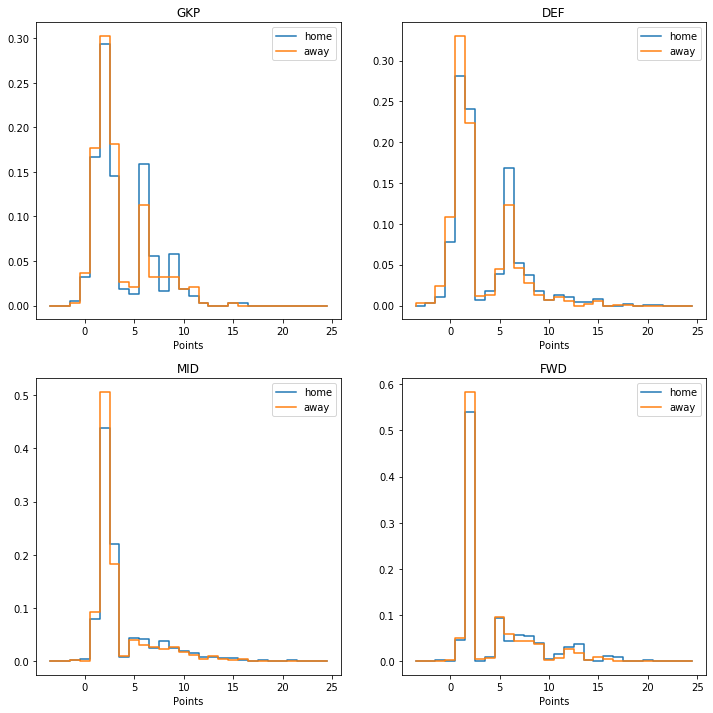

In [10]:
fig,ax = plt.subplots(2,2, figsize=(12,12))

n_points_or_less = np.zeros((4,3), dtype='float')
more_than_n_points = np.zeros((4,3), dtype='float')

n = 2

positions = ['GKP', 'DEF', 'MID', 'FWD']

for i in range(0,4):
    [x,y] = np.unravel_index(i, (2,2))
    
    valid_players_position = valid_players.loc[valid_players['element_type']==i,:]
    home_players_position = home_players.loc[home_players['element_type']==i,:]
    away_players_position = away_players.loc[away_players['element_type']==i,:]
                                             
    (b_h, n_h) = histOutline(home_players_position['total_points'], bins=bins);
    n_h = n_h / len(home_players_position)
    ax[x,y].plot(b_h, n_h)
    
    (b_a, n_a) = histOutline(away_players_position['total_points'], bins=bins);
    n_a = n_a/len(away_players_position)
    ax[x,y].plot(b_a, n_a)
    
    ax[x,y].legend(['home', 'away'])
    ax[x,y].set_xlabel('Points')
    ax[x,y].set_title(positions[i])
    
    n_points_or_less[i,0] = sum(valid_players_position['total_points']<=n)/len(valid_players_position)
    n_points_or_less[i,1] = sum(home_players_position['total_points']<=n)/len(home_players_position)
    n_points_or_less[i,2] = sum(away_players_position['total_points']<=n)/len(away_players_position)
    
    more_than_n_points[i,0] = sum(valid_players_position['total_points']>n)/len(valid_players_position)
    more_than_n_points[i,1] = sum(home_players_position['total_points']>n)/len(home_players_position)
    more_than_n_points[i,2] = sum(away_players_position['total_points']>n)/len(away_players_position)
    

In [11]:
n_points_or_less_df = pd.DataFrame(100*n_points_or_less, columns=['overall', 'home', 'away'], index=positions)
n_points_or_less_df.head()

,overall,home,away
GKP,50.791557,49.735450,51.842105
DEF,65.238402,61.344538,69.107258
MID,56.351690,52.416824,60.262009
FWD,61.336254,59.012876,63.758389


In [12]:
more_than_n_points_df = pd.DataFrame(100*more_than_n_points, columns=['overall', 'home', 'away'], index=positions)
more_than_n_points_df.head()

,overall,home,away
GKP,49.208443,50.264550,48.157895
DEF,34.761598,38.655462,30.892742
MID,43.648310,47.583176,39.737991
FWD,38.663746,40.987124,36.241611
